In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import os
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
from pandas import Series, DataFrame
# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
def load_list(data_dir, prefix = None, dataset = 1):
    train_list = os.path.join(data_dir, 'train') + str(dataset) + '.idx'
    test_list = os.path.join(data_dir, 'test') + str(dataset) + '.idx'
    with open(train_list) as f:
        train_list = f.read().splitlines()
    with open(test_list) as f:
        test_list = f.read().splitlines()
    if prefix is not None:
        train_list = map(lambda x: os.path.join(prefix, x), train_list)
        test_list = map(lambda x: os.path.join(prefix, x), test_list)
    return train_list, test_list

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [147]:
features_name = '1'
n_features = 4096
n_samples_per_fold = 20
dataset = 1

In [148]:
def load_features(video):
    with open(os.path.join('./data/ArrowDataAll', video, 'features' + features_name + '.csv'), 'r') as f:
        X = np.loadtxt(f, delimiter = ',')
    with open(os.path.join('./data/ArrowDataAll', video, 'labels' + features_name + '.csv'), 'r') as f:
        y = np.loadtxt(f, delimiter = ',')
    video_names_with_multitude = [video] * len(y)
    return X, y, video_names_with_multitude

In [149]:
train_list, test_list = load_list('./data', dataset = dataset)

In [150]:
X_train = np.empty((0, n_features))
y_train = np.empty(0)
video_train = []
for video in train_list:
    if train_list.index(video) % 10 == 0:
        print train_list.index(video)+1
    X, y, video_names_with_multitude = load_features(video)
    X_train = np.append(X_train, X, axis = 0)
    y_train = np.append(y_train, y, axis = 0)
    video_train.extend(video_names_with_multitude)

1
11
21
31
41
51
61
71
81
91
101
111


In [151]:
X_test = np.empty((0, n_features))
y_test = np.empty(0)
video_test = []
for video in test_list:
    if test_list.index(video) % 10 == 0:
        print test_list.index(video)+1
    X, y, video_names_with_multitude = load_features(video)
    X_test = np.append(X_test, X, axis = 0)
    y_test = np.append(y_test, y, axis = 0)
    video_test.extend(video_names_with_multitude)

1
11
21
31
41
51


## Feature importance

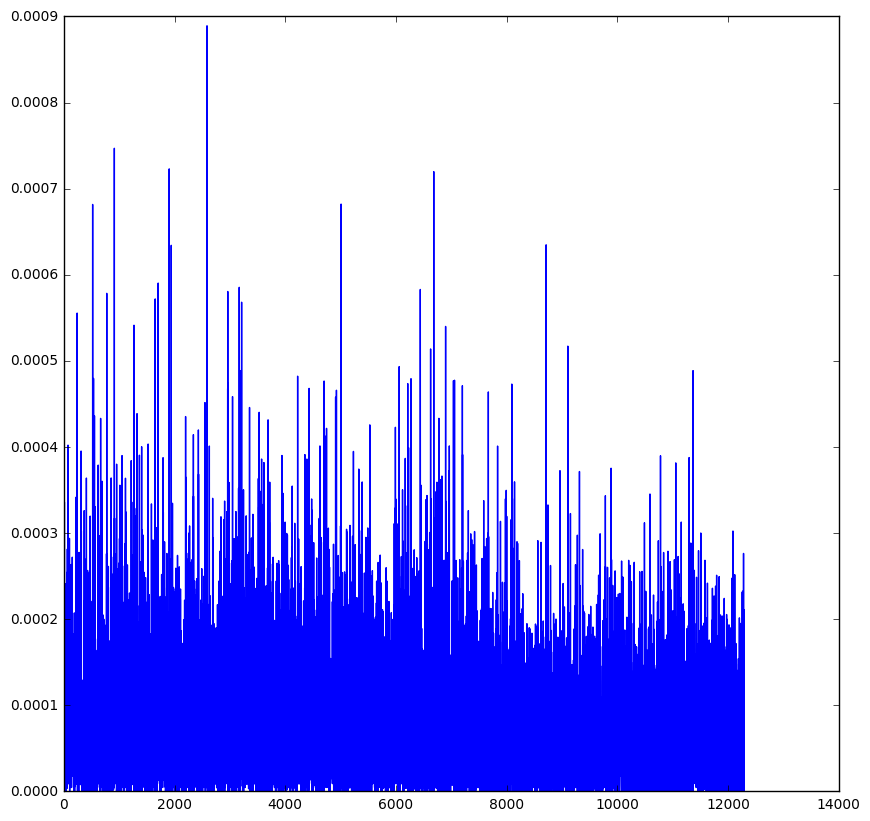

In [146]:
clf = RandomForestClassifier(n_jobs = -1, n_estimators=100)
clf.fit(X_train, y_train)
plt.plot(clf.feature_importances_)
plt.savefig('../report/figs/importance-f' + str(features_name) + '-d' + str(dataset) + '.pdf')

In [152]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=100)
#clf = SVC(C=10, kernel = 'linear')
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [125]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':['linear'], 'C':[0.1, 1, 10, 100]}
#svc = SVC()
#clf = GridSearchCV(svc, parameters, n_jobs = -1)
#clf.fit(X_train, y_train)

In [126]:
print clf.score(X_test, y_test)

0.483333333333


In [153]:
y_predict = clf.predict(X_test)

In [154]:
df = DataFrame(Series(y_test))
df[1] = Series(y_predict)
df[2] = Series(video_test)
df.columns = ['true', 'predict', 'video']

In [155]:
fold = [['A']*n_samples_per_fold + ['B']*n_samples_per_fold + ['C']*n_samples_per_fold + ['D']*n_samples_per_fold]*60

In [156]:
import itertools
fold = list(itertools.chain(*fold))
df['fold'] = Series(fold)

In [157]:
df

,true,predict,video,fold
0,1.0,1.0,F_ebcfFg2ihYw,A
1,1.0,0.0,F_ebcfFg2ihYw,A
2,1.0,1.0,F_ebcfFg2ihYw,A
3,1.0,1.0,F_ebcfFg2ihYw,A
4,1.0,1.0,F_ebcfFg2ihYw,A
5,1.0,1.0,F_ebcfFg2ihYw,A
6,1.0,1.0,F_ebcfFg2ihYw,A
7,1.0,0.0,F_ebcfFg2ihYw,A
8,1.0,1.0,F_ebcfFg2ihYw,A
9,1.0,1.0,F_ebcfFg2ihYw,A


In [158]:
dfg = df.groupby(['video', 'fold']).mean().unstack()

In [159]:
dfg

true                predict                  
fold             A    B    C    D       A     B     C     D
video                                                      
B1ADMcXAQCzo0  0.0  0.0  1.0  1.0    0.40  0.55  0.65  0.50
B1RsaXI-SKchA  0.0  0.0  1.0  1.0    0.15  0.20  0.50  0.45
B1U5XS34QmUuI  0.0  0.0  1.0  1.0    0.45  0.45  0.70  0.65
B1mOABN2abDq0  0.0  0.0  1.0  1.0    0.50  0.45  0.40  0.45
B1uglCr8ueyv8  0.0  0.0  1.0  1.0    0.25  0.30  0.25  0.40
B2ADMcXAQCzo0  0.0  0.0  1.0  1.0    0.35  0.40  0.55  0.60
B301TL9bUWr6I  0.0  0.0  1.0  1.0    0.55  0.65  0.70  0.55
B401TL9bUWr6I  0.0  0.0  1.0  1.0    0.65  0.80  0.35  0.25
B5X6jprOZ29wY  0.0  0.0  1.0  1.0    0.60  0.15  0.45  0.30
F_05gGCvIopwE  1.0  1.0  0.0  0.0    0.65  0.30  0.40  0.40
F_2NOQEJKLqks  1.0  1.0  0.0  0.0    0.65  0.65  0.60  0.55
F_3DL_97x0dpQ  1.0  1.0  0.0  0.0    0.60  0.65  0.60  0.60
F_3c66YWCXdbU  1.0  1.0  0.0  0.0    0.65  0.35  0.55  0.50
F_69RNNex-sig  1.0  1.0  0.0  0.0    0.50  0.65  0.90  0.65
F_6ClKTIhJizQ  1.0  1.0  0.0  0.0    0.45  0.60  0.25  0.30
F_6d6oBTmEbRM  1.0  1.0  0.0  0.0    0.40  0.60  0.45  0.70
F_94HqFht60Ek  1.0  1.0  0.0  0.0    0.30  0.45  0.20  0.20
F_EIh4VpXQ8HU  1.0  1.0  0.0  0.0    0.45  0.65  0.80  0.70
F_EbU7VPY4QIA  1.0  1.0  0.0  0.0    0.55  0.65  0.50  0.60
F_FaAjPRKXXv0  1.0  1.0  0.0  0.0    0.45  0.40  0.30  0.40
F_FriaMvobUi0  1.0  1.0  0.0  0.0    0.65  0.50  0.55  0.45
F_G4VKPR67xYs  1.0  1.0  0.0  0.0    0.70  0.50  0.30  0.40
F_HFkYJofKBis  1.0  1.0  0.0  0.0    0.35  0.30  0.20  0.35
F_IBp5Aip2Vw0  1.0  1.0  0.0  0.0    0.25  0.35  0.45  0.45
F_MTXhdrkEtoE  1.0  1.0  0.0  0.0    0.35  0.40  0.35  0.35
F_O2VWbZIrMuw  1.0  1.0  0.0  0.0    0.55  0.55  0.50  0.50
F_PosKL3to6l8  1.0  1.0  0.0  0.0    0.35  0.35  0.45  0.55
F_Rv0sbR0lbDg  1.0  1.0  0.0  0.0    0.05  0.15  0.10  0.05
F_SyO3YwrsJPg  1.0  1.0  0.0  0.0    0.25  0.30  0.30  0.35
F_W8X7EFqVqNc  1.0  1.0  0.0  0.0    0.45  0.40  0.40  0.55
F_XDpOtZ-sdQE  1.0  1.0  0.0  0.0    0.30  0.45  0.60  0.45
F__18hsqaDrHs  1.0  1.0  0.0  0.0    0.45  0.20  0.45  0.40
F__RiKnRbBhtQ  1.0  1.0  0.0  0.0    0.25  0.45  0.40  0.55
F_aDEecz10DnY  1.0  1.0  0.0  0.0    0.40  0.45  0.30  0.40
F_b-MbEx1Iqj8  1.0  1.0  0.0  0.0    0.35  0.45  0.55  0.35
F_bYepd01KDFw  1.0  1.0  0.0  0.0    0.85  0.75  0.55  0.60
F_cCMzlrpWHgo  1.0  1.0  0.0  0.0    0.75  0.75  0.65  0.50
F_dhfcutcvsLU  1.0  1.0  0.0  0.0    0.40  0.40  0.40  0.30
F_ebcfFg2ihYw  1.0  1.0  0.0  0.0    0.75  0.40  0.30  0.30
F_fPZNvBcoOtE  1.0  1.0  0.0  0.0    0.30  0.25  0.35  0.30
F_fc8LngsvxUc  1.0  1.0  0.0  0.0    0.20  0.20  0.45  0.55
F_gQXKFNJBgIc  1.0  1.0  0.0  0.0    0.45  0.40  0.50  0.55
F_hyGJBV1xnJI  1.0  1.0  0.0  0.0    0.70  0.60  0.30  0.30
F_jmgV3OFn0aE  1.0  1.0  0.0  0.0    0.40  0.60  0.65  0.40
F_k7viIK45xGQ  1.0  1.0  0.0  0.0    0.65  0.40  0.25  0.20
F_kJGQy-j3Nx4  1.0  1.0  0.0  0.0    0.70  0.55  0.55  0.45
F_kWetGqX9uFc  1.0  1.0  0.0  0.0    0.65  0.55  0.45  0.60
F_kxCEpfTSfJU  1.0  1.0  0.0  0.0    0.60  0.35  0.65  0.50
F_lanCzRFNoy8  1.0  1.0  0.0  0.0    0.70  0.40  0.25  0.15
F_n1cCs-S5EKc  1.0  1.0  0.0  0.0    0.30  0.75  0.05  0.15
F_n4MsOeSmwbs  1.0  1.0  0.0  0.0    0.75  0.65  0.65  0.60
F_oB2W0HIgpHg  1.0  1.0  0.0  0.0    0.70  0.70  0.15  0.55
F_pZcB4oJ5jsc  1.0  1.0  0.0  0.0    0.40  0.35  0.35  0.20
F_pdy9isqFDxE  1.0  1.0  0.0  0.0    0.45  0.40  0.35  0.40
F_qVH7ZUbowMU  1.0  1.0  0.0  0.0    0.55  0.60  0.25  0.15
F_tfMMAwlD7gs  1.0  1.0  0.0  0.0    0.45  0.35  0.55  0.65
F_uJzAPp8C2zA  1.0  1.0  0.0  0.0    0.65  0.60  0.40  0.35
F_uvTMZmUdSsc  1.0  1.0  0.0  0.0    0.45  0.50  0.30  0.40
F_x90_QK5U6WY  1.0  1.0  0.0  0.0    0.55  0.50  0.25  0.15
F_y7-0L0kFnqA  1.0  1.0  0.0  0.0    0.85  0.95  0.35  0.40

In [160]:
dfg['gt'] = dfg.apply(lambda x: (x['true']['A'] + x['true']['B']- x['true']['C']-x['true']['D']) > 0, axis = 1)
dfg['my'] = dfg.apply(lambda x: (x['predict']['A'] + x['predict']['B']- x['predict']['C']-x['predict']['D'])>=0, axis = 1)

In [161]:
dfg

true                predict                       gt     my
fold             A    B    C    D       A     B     C     D              
video                                                                    
B1ADMcXAQCzo0  0.0  0.0  1.0  1.0    0.40  0.55  0.65  0.50  False  False
B1RsaXI-SKchA  0.0  0.0  1.0  1.0    0.15  0.20  0.50  0.45  False  False
B1U5XS34QmUuI  0.0  0.0  1.0  1.0    0.45  0.45  0.70  0.65  False  False
B1mOABN2abDq0  0.0  0.0  1.0  1.0    0.50  0.45  0.40  0.45  False   True
B1uglCr8ueyv8  0.0  0.0  1.0  1.0    0.25  0.30  0.25  0.40  False  False
B2ADMcXAQCzo0  0.0  0.0  1.0  1.0    0.35  0.40  0.55  0.60  False  False
B301TL9bUWr6I  0.0  0.0  1.0  1.0    0.55  0.65  0.70  0.55  False  False
B401TL9bUWr6I  0.0  0.0  1.0  1.0    0.65  0.80  0.35  0.25  False   True
B5X6jprOZ29wY  0.0  0.0  1.0  1.0    0.60  0.15  0.45  0.30  False   True
F_05gGCvIopwE  1.0  1.0  0.0  0.0    0.65  0.30  0.40  0.40   True   True
F_2NOQEJKLqks  1.0  1.0  0.0  0.0    0.65  0.65  0.60  0.55   True   True
F_3DL_97x0dpQ  1.0  1.0  0.0  0.0    0.60  0.65  0.60  0.60   True   True
F_3c66YWCXdbU  1.0  1.0  0.0  0.0    0.65  0.35  0.55  0.50   True  False
F_69RNNex-sig  1.0  1.0  0.0  0.0    0.50  0.65  0.90  0.65   True  False
F_6ClKTIhJizQ  1.0  1.0  0.0  0.0    0.45  0.60  0.25  0.30   True   True
F_6d6oBTmEbRM  1.0  1.0  0.0  0.0    0.40  0.60  0.45  0.70   True  False
F_94HqFht60Ek  1.0  1.0  0.0  0.0    0.30  0.45  0.20  0.20   True   True
F_EIh4VpXQ8HU  1.0  1.0  0.0  0.0    0.45  0.65  0.80  0.70   True  False
F_EbU7VPY4QIA  1.0  1.0  0.0  0.0    0.55  0.65  0.50  0.60   True   True
F_FaAjPRKXXv0  1.0  1.0  0.0  0.0    0.45  0.40  0.30  0.40   True   True
F_FriaMvobUi0  1.0  1.0  0.0  0.0    0.65  0.50  0.55  0.45   True   True
F_G4VKPR67xYs  1.0  1.0  0.0  0.0    0.70  0.50  0.30  0.40   True   True
F_HFkYJofKBis  1.0  1.0  0.0  0.0    0.35  0.30  0.20  0.35   True   True
F_IBp5Aip2Vw0  1.0  1.0  0.0  0.0    0.25  0.35  0.45  0.45   True  False
F_MTXhdrkEtoE  1.0  1.0  0.0  0.0    0.35  0.40  0.35  0.35   True   True
F_O2VWbZIrMuw  1.0  1.0  0.0  0.0    0.55  0.55  0.50  0.50   True   True
F_PosKL3to6l8  1.0  1.0  0.0  0.0    0.35  0.35  0.45  0.55   True  False
F_Rv0sbR0lbDg  1.0  1.0  0.0  0.0    0.05  0.15  0.10  0.05   True   True
F_SyO3YwrsJPg  1.0  1.0  0.0  0.0    0.25  0.30  0.30  0.35   True  False
F_W8X7EFqVqNc  1.0  1.0  0.0  0.0    0.45  0.40  0.40  0.55   True  False
F_XDpOtZ-sdQE  1.0  1.0  0.0  0.0    0.30  0.45  0.60  0.45   True  False
F__18hsqaDrHs  1.0  1.0  0.0  0.0    0.45  0.20  0.45  0.40   True  False
F__RiKnRbBhtQ  1.0  1.0  0.0  0.0    0.25  0.45  0.40  0.55   True  False
F_aDEecz10DnY  1.0  1.0  0.0  0.0    0.40  0.45  0.30  0.40   True   True
F_b-MbEx1Iqj8  1.0  1.0  0.0  0.0    0.35  0.45  0.55  0.35   True  False
F_bYepd01KDFw  1.0  1.0  0.0  0.0    0.85  0.75  0.55  0.60   True   True
F_cCMzlrpWHgo  1.0  1.0  0.0  0.0    0.75  0.75  0.65  0.50   True   True
F_dhfcutcvsLU  1.0  1.0  0.0  0.0    0.40  0.40  0.40  0.30   True   True
F_ebcfFg2ihYw  1.0  1.0  0.0  0.0    0.75  0.40  0.30  0.30   True   True
F_fPZNvBcoOtE  1.0  1.0  0.0  0.0    0.30  0.25  0.35  0.30   True  False
F_fc8LngsvxUc  1.0  1.0  0.0  0.0    0.20  0.20  0.45  0.55   True  False
F_gQXKFNJBgIc  1.0  1.0  0.0  0.0    0.45  0.40  0.50  0.55   True  False
F_hyGJBV1xnJI  1.0  1.0  0.0  0.0    0.70  0.60  0.30  0.30   True   True
F_jmgV3OFn0aE  1.0  1.0  0.0  0.0    0.40  0.60  0.65  0.40   True  False
F_k7viIK45xGQ  1.0  1.0  0.0  0.0    0.65  0.40  0.25  0.20   True   True
F_kJGQy-j3Nx4  1.0  1.0  0.0  0.0    0.70  0.55  0.55  0.45   True   True
F_kWetGqX9uFc  1.0  1.0  0.0  0.0    0.65  0.55  0.45  0.60   True   True
F_kxCEpfTSfJU  1.0  1.0  0.0  0.0    0.60  0.35  0.65  0.50   True  False
F_lanCzRFNoy8  1.0  1.0  0.0  0.0    0.70  0.40  0.25  0.15   True   True
F_n1cCs-S5EKc  1.0  1.0  0.0  0.0    0.30  0.75  0.05  0.15   True   True
F_n4MsOeSmwbs  1.0  1.0  0.0  0.0    0.75  0.65  0.65  0.60   True   True
F_oB2W0HIgpHg  1.0

In [162]:
dfg['good'] = dfg['gt'] == dfg['my']

In [163]:
dfg

true                predict                       gt     my  \
fold             A    B    C    D       A     B     C     D                 
video                                                                       
B1ADMcXAQCzo0  0.0  0.0  1.0  1.0    0.40  0.55  0.65  0.50  False  False   
B1RsaXI-SKchA  0.0  0.0  1.0  1.0    0.15  0.20  0.50  0.45  False  False   
B1U5XS34QmUuI  0.0  0.0  1.0  1.0    0.45  0.45  0.70  0.65  False  False   
B1mOABN2abDq0  0.0  0.0  1.0  1.0    0.50  0.45  0.40  0.45  False   True   
B1uglCr8ueyv8  0.0  0.0  1.0  1.0    0.25  0.30  0.25  0.40  False  False   
B2ADMcXAQCzo0  0.0  0.0  1.0  1.0    0.35  0.40  0.55  0.60  False  False   
B301TL9bUWr6I  0.0  0.0  1.0  1.0    0.55  0.65  0.70  0.55  False  False   
B401TL9bUWr6I  0.0  0.0  1.0  1.0    0.65  0.80  0.35  0.25  False   True   
B5X6jprOZ29wY  0.0  0.0  1.0  1.0    0.60  0.15  0.45  0.30  False   True   
F_05gGCvIopwE  1.0  1.0  0.0  0.0    0.65  0.30  0.40  0.40   True   True   
F_2NOQEJKLqks  1.0  1.0  0.0  0.0    0.65  0.65  0.60  0.55   True   True   
F_3DL_97x0dpQ  1.0  1.0  0.0  0.0    0.60  0.65  0.60  0.60   True   True   
F_3c66YWCXdbU  1.0  1.0  0.0  0.0    0.65  0.35  0.55  0.50   True  False   
F_69RNNex-sig  1.0  1.0  0.0  0.0    0.50  0.65  0.90  0.65   True  False   
F_6ClKTIhJizQ  1.0  1.0  0.0  0.0    0.45  0.60  0.25  0.30   True   True   
F_6d6oBTmEbRM  1.0  1.0  0.0  0.0    0.40  0.60  0.45  0.70   True  False   
F_94HqFht60Ek  1.0  1.0  0.0  0.0    0.30  0.45  0.20  0.20   True   True   
F_EIh4VpXQ8HU  1.0  1.0  0.0  0.0    0.45  0.65  0.80  0.70   True  False   
F_EbU7VPY4QIA  1.0  1.0  0.0  0.0    0.55  0.65  0.50  0.60   True   True   
F_FaAjPRKXXv0  1.0  1.0  0.0  0.0    0.45  0.40  0.30  0.40   True   True   
F_FriaMvobUi0  1.0  1.0  0.0  0.0    0.65  0.50  0.55  0.45   True   True   
F_G4VKPR67xYs  1.0  1.0  0.0  0.0    0.70  0.50  0.30  0.40   True   True   
F_HFkYJofKBis  1.0  1.0  0.0  0.0    0.35  0.30  0.20  0.35   True   True   
F_IBp5Aip2Vw0  1.0  1.0  0.0  0.0    0.25  0.35  0.45  0.45   True  False   
F_MTXhdrkEtoE  1.0  1.0  0.0  0.0    0.35  0.40  0.35  0.35   True   True   
F_O2VWbZIrMuw  1.0  1.0  0.0  0.0    0.55  0.55  0.50  0.50   True   True   
F_PosKL3to6l8  1.0  1.0  0.0  0.0    0.35  0.35  0.45  0.55   True  False   
F_Rv0sbR0lbDg  1.0  1.0  0.0  0.0    0.05  0.15  0.10  0.05   True   True   
F_SyO3YwrsJPg  1.0  1.0  0.0  0.0    0.25  0.30  0.30  0.35   True  False   
F_W8X7EFqVqNc  1.0  1.0  0.0  0.0    0.45  0.40  0.40  0.55   True  False   
F_XDpOtZ-sdQE  1.0  1.0  0.0  0.0    0.30  0.45  0.60  0.45   True  False   
F__18hsqaDrHs  1.0  1.0  0.0  0.0    0.45  0.20  0.45  0.40   True  False   
F__RiKnRbBhtQ  1.0  1.0  0.0  0.0    0.25  0.45  0.40  0.55   True  False   
F_aDEecz10DnY  1.0  1.0  0.0  0.0    0.40  0.45  0.30  0.40   True   True   
F_b-MbEx1Iqj8  1.0  1.0  0.0  0.0    0.35  0.45  0.55  0.35   True  False   
F_bYepd01KDFw  1.0  1.0  0.0  0.0    0.85  0.75  0.55  0.60   True   True   
F_cCMzlrpWHgo  1.0  1.0  0.0  0.0    0.75  0.75  0.65  0.50   True   True   
F_dhfcutcvsLU  1.0  1.0  0.0  0.0    0.40  0.40  0.40  0.30   True   True   
F_ebcfFg2ihYw  1.0  1.0  0.0  0.0    0.75  0.40  0.30  0.30   True   True   
F_fPZNvBcoOtE  1.0  1.0  0.0  0.0    0.30  0.25  0.35  0.30   True  False   
F_fc8LngsvxUc  1.0  1.0  0.0  0.0    0.20  0.20  0.45  0.55   True  False   
F_gQXKFNJBgIc  1.0  1.0  0.0  0.0    0.45  0.40  0.50  0.55   True  False   
F_hyGJBV1xnJI  1.0  1.0  0.0  0.0    0.70  0.60  0.30  0.30   True   True   
F_jmgV3OFn0aE  1.0  1.0  0.0  0.0    0.40  0.60  0.65  0.40   True  False   
F_k7viIK45xGQ  1.0  1.0  0.0  0.0    0.65  0.40  0.25  0.20   True   True   
F_kJGQy-j3Nx4  1.0  1.0  0.0  0.0    0.70  0.55  0.55  0.45   True   True   
F_kWetGqX9uFc  1.0  1.0  0.0  0.0    0.65  0.55  0.45  0.60   True   True   
F_kxCEpfTSfJU  1.0  1.0  0.0  0.0    0.60  0.35  0.65  0.50   True  False   
F_lanCzRFNoy8  1.0  1.0  0.0  0.0    0.70  0.40  0.25  0.15   True   True   
F_n1cCs-S5

In [138]:
dfg['good'].mean()

0.59999999999999998

In [139]:
cm = confusion_matrix(dfg['gt'], dfg['my'])

Confusion matrix, without normalization
[[ 3  5]
 [19 33]]


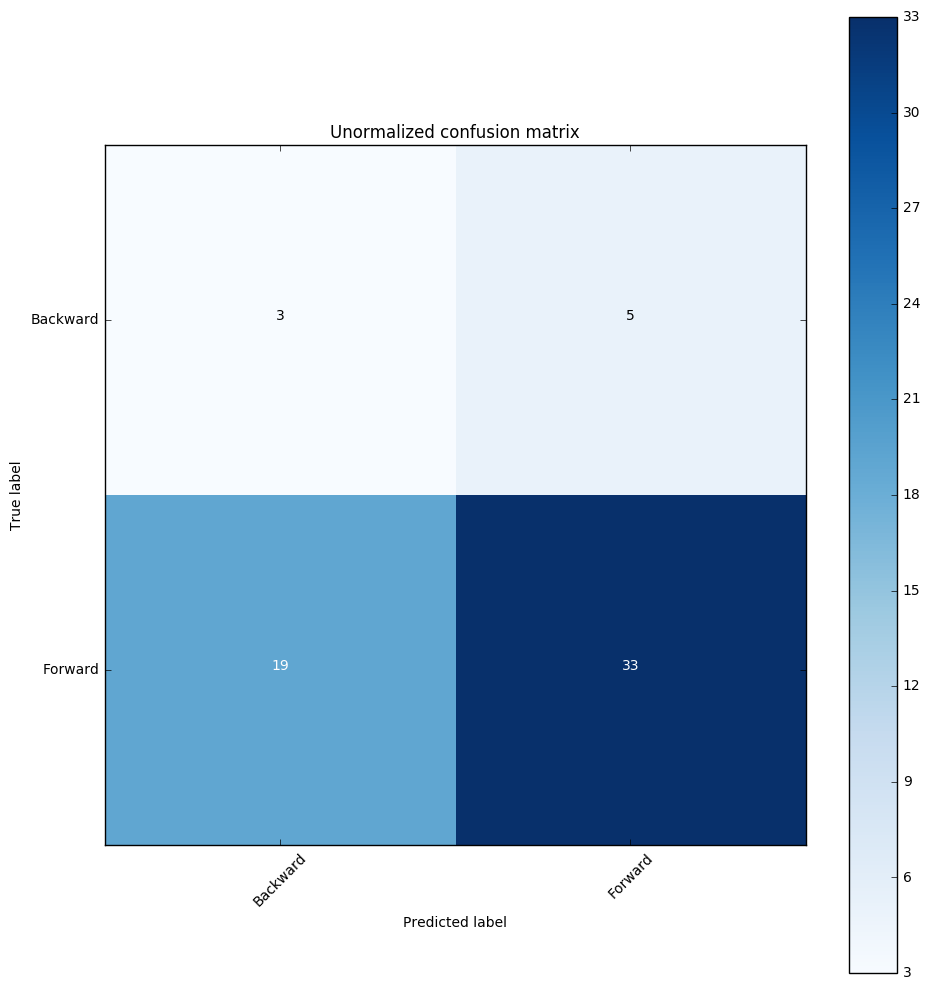

In [140]:
plot_confusion_matrix(cm, classes=['Backward', 'Forward'], normalize=False,
                      title='Unormalized confusion matrix')
plt.tight_layout()
plt.savefig('../report/figs/cm-f' + str(features_name) + '-d' + str(dataset) + '.pdf')